In [83]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mplhep

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

mplhep.style.use(["LHCbTex2"])
input_tree = uproot.open(
    {
        "/work/cetin/LHCb/reco_tuner/data/tracking_losses_ntuple_B_BJpsi_def_selected.root": "Selected"
    }
)
array = input_tree.arrays()

array["yStraightOut"] = array["ideal_state_770_y"] + array["ideal_state_770_ty"] * (
    array["ideal_state_10000_z"] - array["ideal_state_770_z"]
)
array["yDiffOut"] = array["ideal_state_10000_y"] - array["yStraightOut"]
array["yStraightEndT"] = array["ideal_state_770_y"] + array["ideal_state_770_ty"] * (
    9410.0 - array["ideal_state_770_z"]
)
array["yDiffEndT"] = array["ideal_state_9410_y"] - array["yStraightEndT"]

array["dSlope_xEndT"] = array["ideal_state_9410_tx"] - array["ideal_state_770_tx"]
array["dSlope_yEndT"] = array["ideal_state_9410_ty"] - array["ideal_state_770_ty"]
array["dSlope_xEndT_abs"] = abs(array["dSlope_xEndT"])
array["dSlope_yEndT_abs"] = abs(array["dSlope_yEndT"])


def format_array(name, coef):
    coef = [str(c) + "f" for c in coef if c != 0.0]
    code = f"constexpr std::array {name}"
    code += "{" + ", ".join(list(coef)) + "};"
    return code

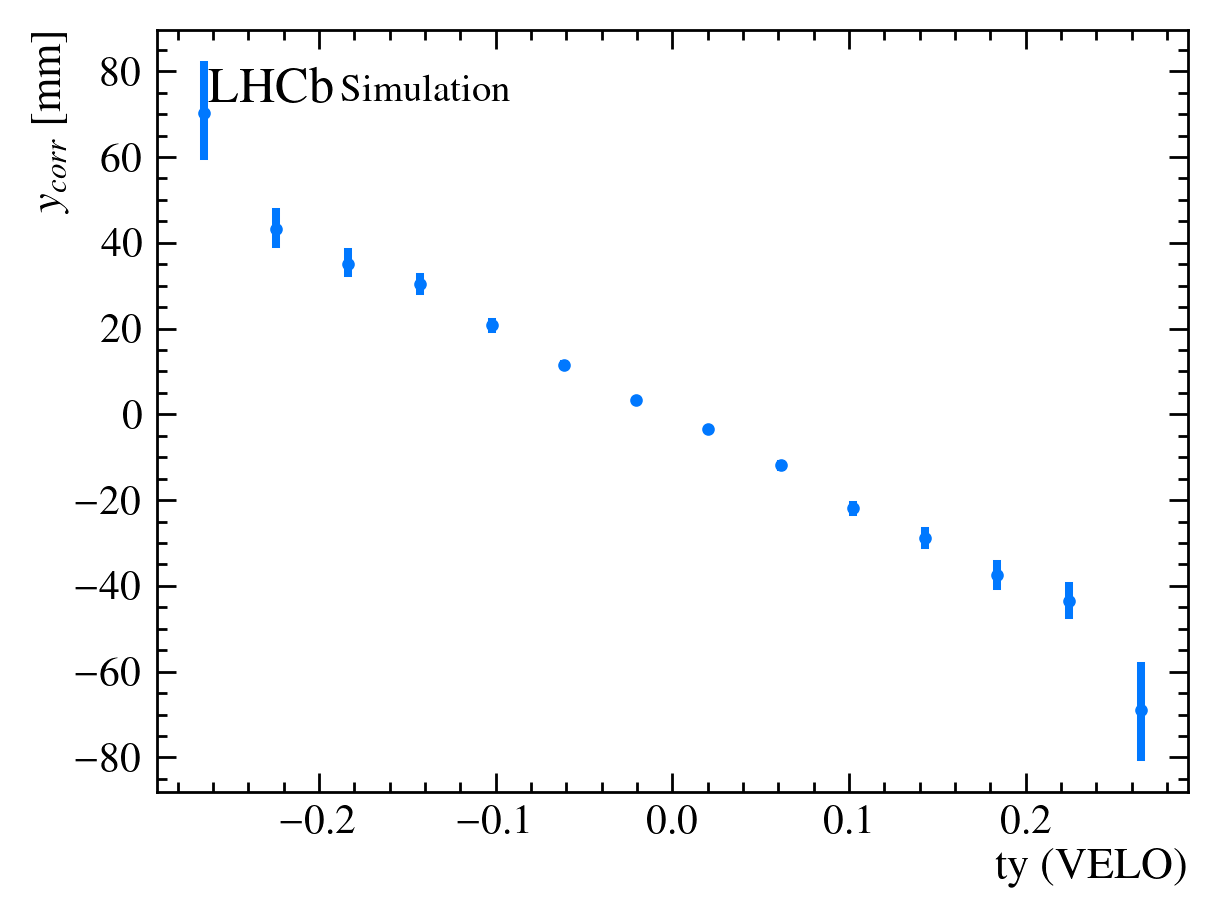

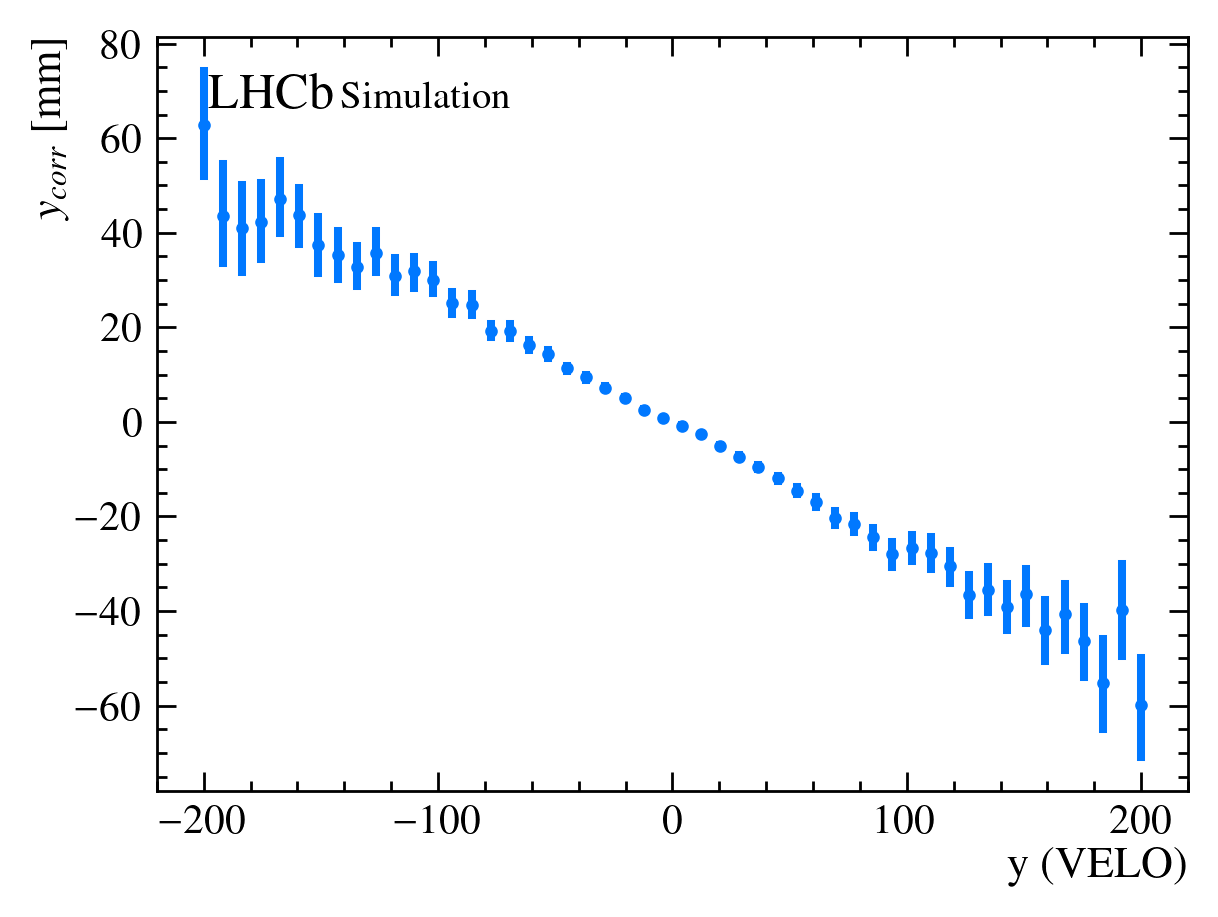

In [54]:
bins = np.linspace(-200, 200, 50)
sns.regplot(
    x=ak.to_numpy(array["ideal_state_770_y"]),
    y=ak.to_numpy(array["yDiffOut"]),
    x_bins=bins,
    fit_reg=None,
    x_estimator=np.mean,
)
plt.xlabel("y (VELO)")
plt.ylabel("$y_{corr}$ [mm]")
mplhep.lhcb.text("Simulation")
plt.show()

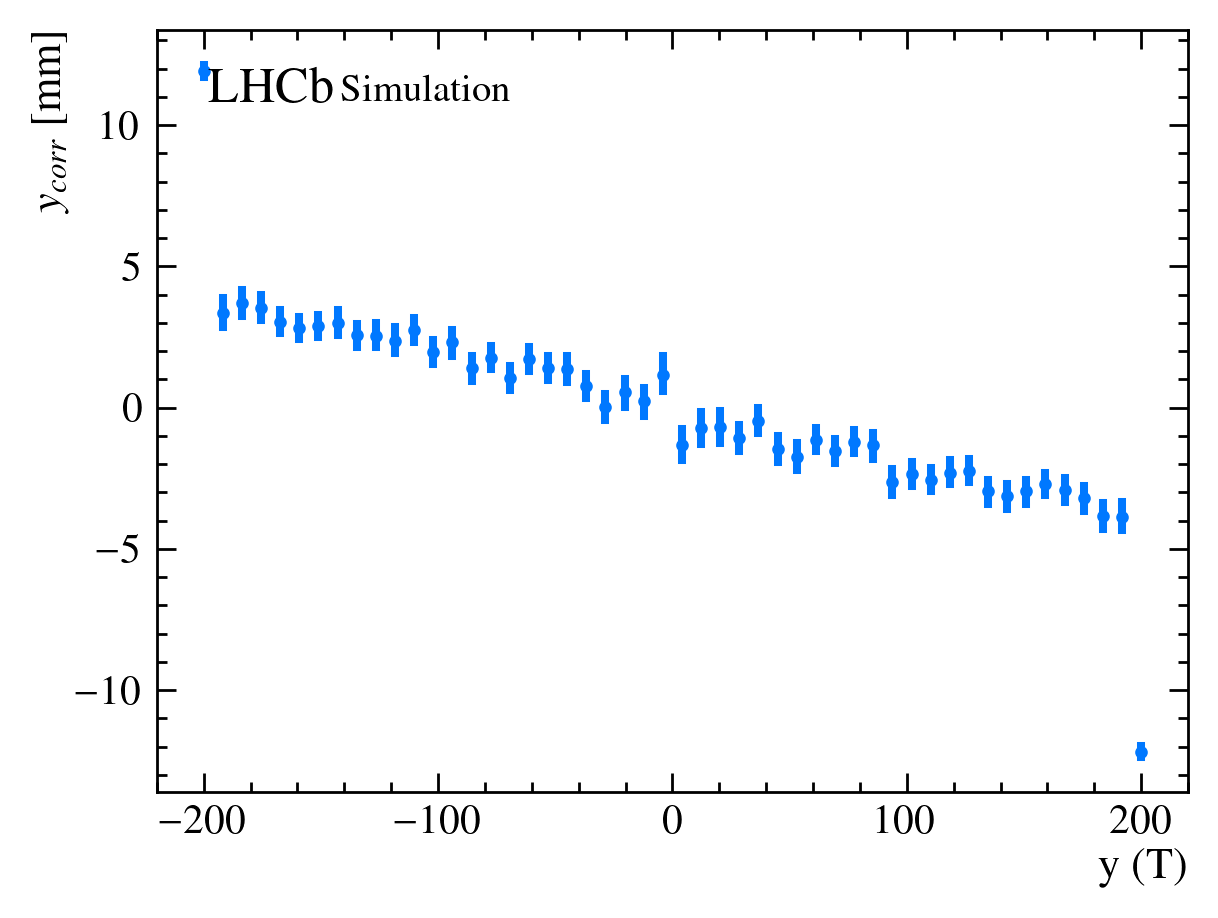

In [55]:
bins = np.linspace(-200, 200, 50)
sns.regplot(
    x=ak.to_numpy(array["ideal_state_9410_y"]),
    y=ak.to_numpy(array["yDiffOut"]),
    x_bins=bins,
    fit_reg=None,
    x_estimator=np.mean,
)
plt.xlabel("y (T)")
plt.ylabel("$y_{corr}$ [mm]")
mplhep.lhcb.text("Simulation")
plt.show()

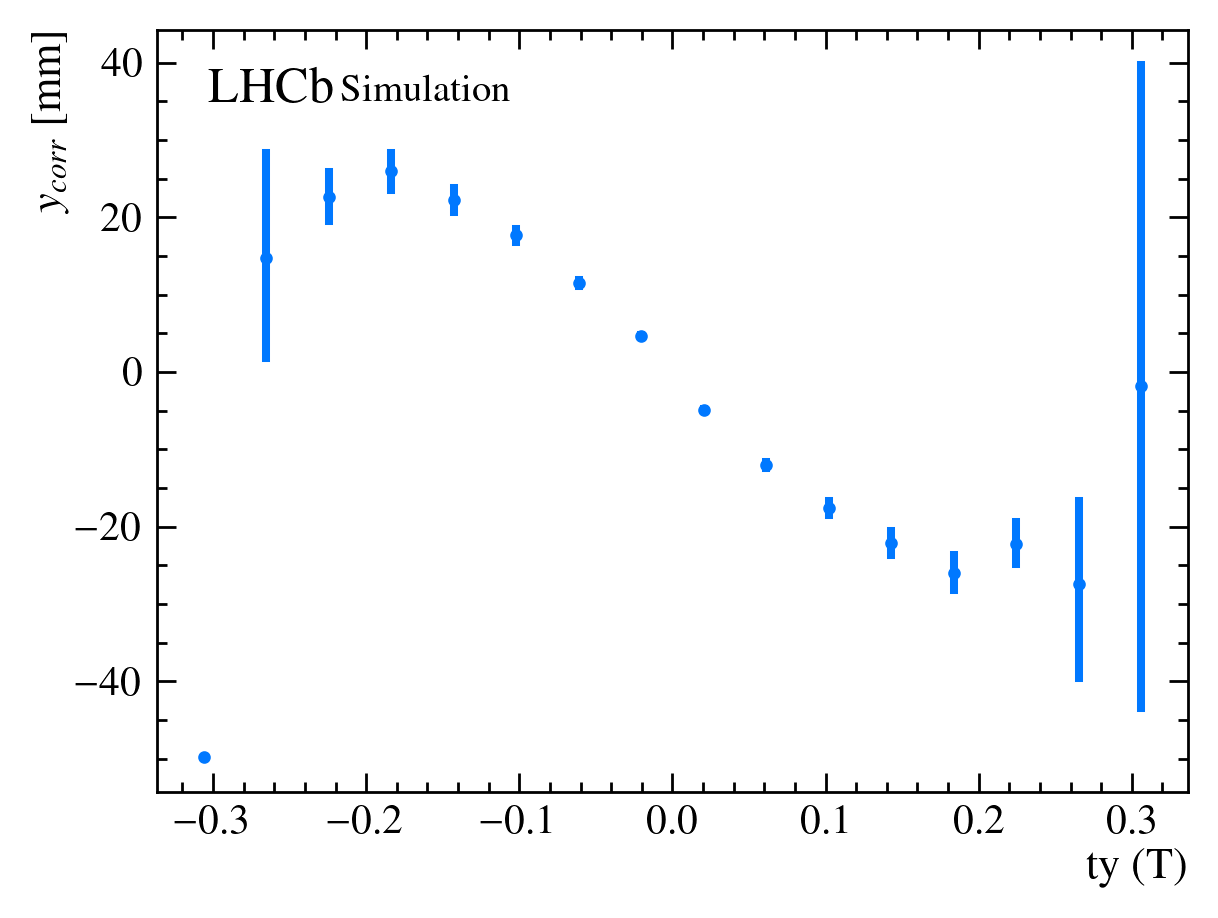

In [56]:
bins = np.linspace(-1, 1, 50)
sns.regplot(
    x=ak.to_numpy(array["ideal_state_9410_ty"]),
    y=ak.to_numpy(array["yDiffOut"]),
    x_bins=bins,
    fit_reg=None,
    x_estimator=np.mean,
)
plt.xlabel("ty (T)")
plt.ylabel("$y_{corr}$ [mm]")
mplhep.lhcb.text("Simulation")
plt.show()

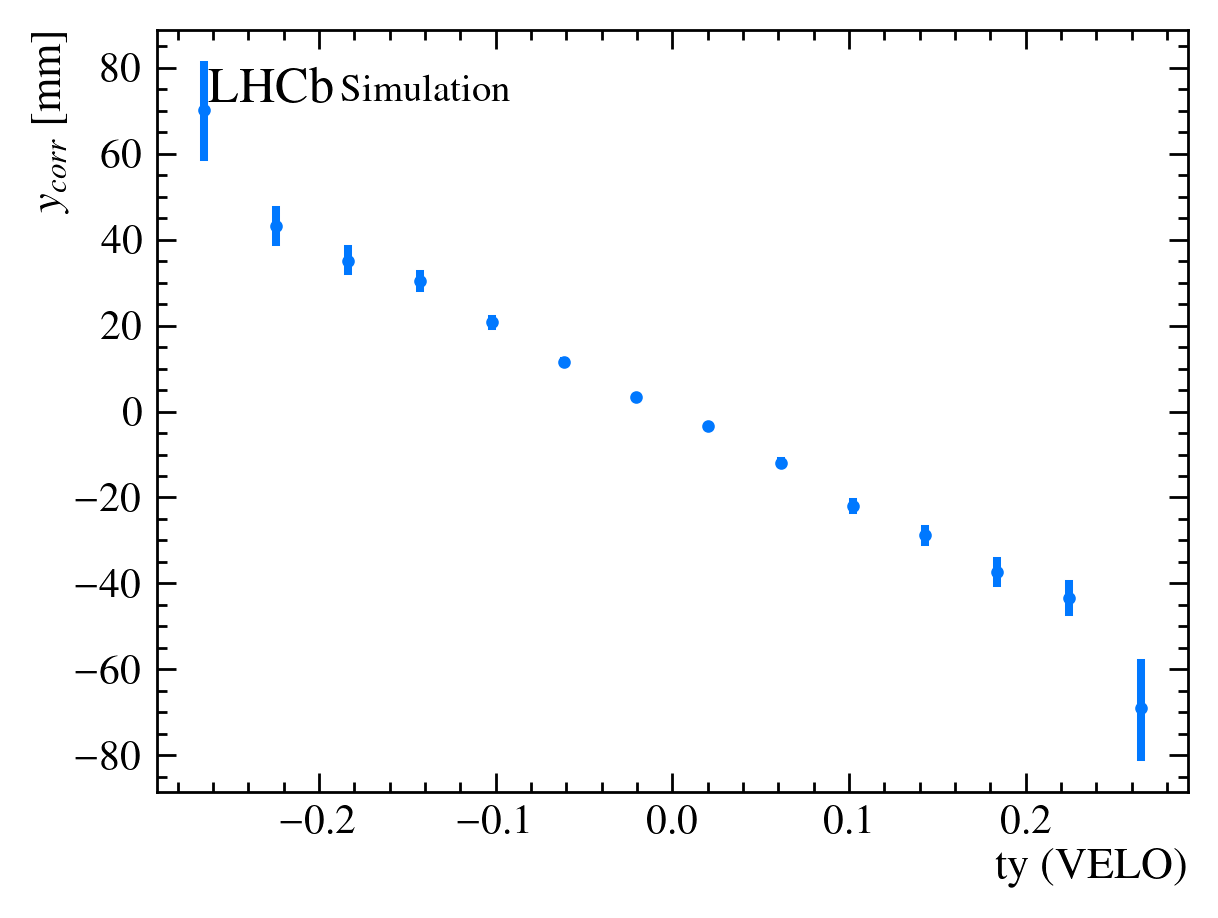

In [76]:
bins = np.linspace(-1, 1, 50)
sns.regplot(
    x=ak.to_numpy(array["ideal_state_770_ty"]),
    y=ak.to_numpy(array["yDiffOut"]),
    x_bins=bins,
    fit_reg=None,
    x_estimator=np.mean,
)
plt.xlabel("ty (VELO)")
plt.ylabel("$y_{corr}$ [mm]")
mplhep.lhcb.text("Simulation")
plt.show()

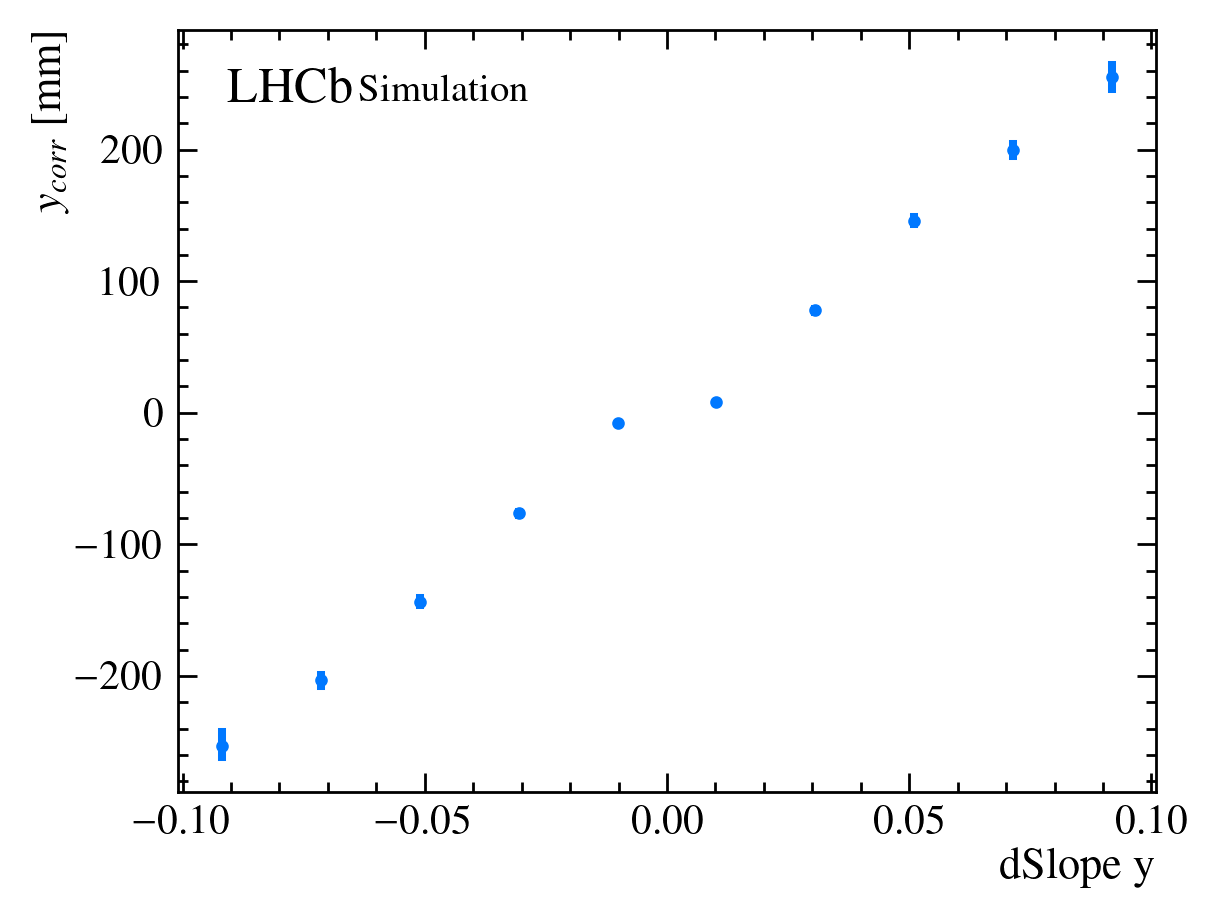

In [74]:
bins = np.linspace(-0.5, 0.5, 50)
sns.regplot(
    x=ak.to_numpy(array["dSlope_yEndT"]),
    y=ak.to_numpy(array["yDiffOut"]),
    x_bins=bins,
    fit_reg=None,
    x_estimator=np.mean,
)
plt.xlabel("dSlope y")
plt.ylabel("$y_{corr}$ [mm]")
mplhep.lhcb.text("Simulation")
plt.show()

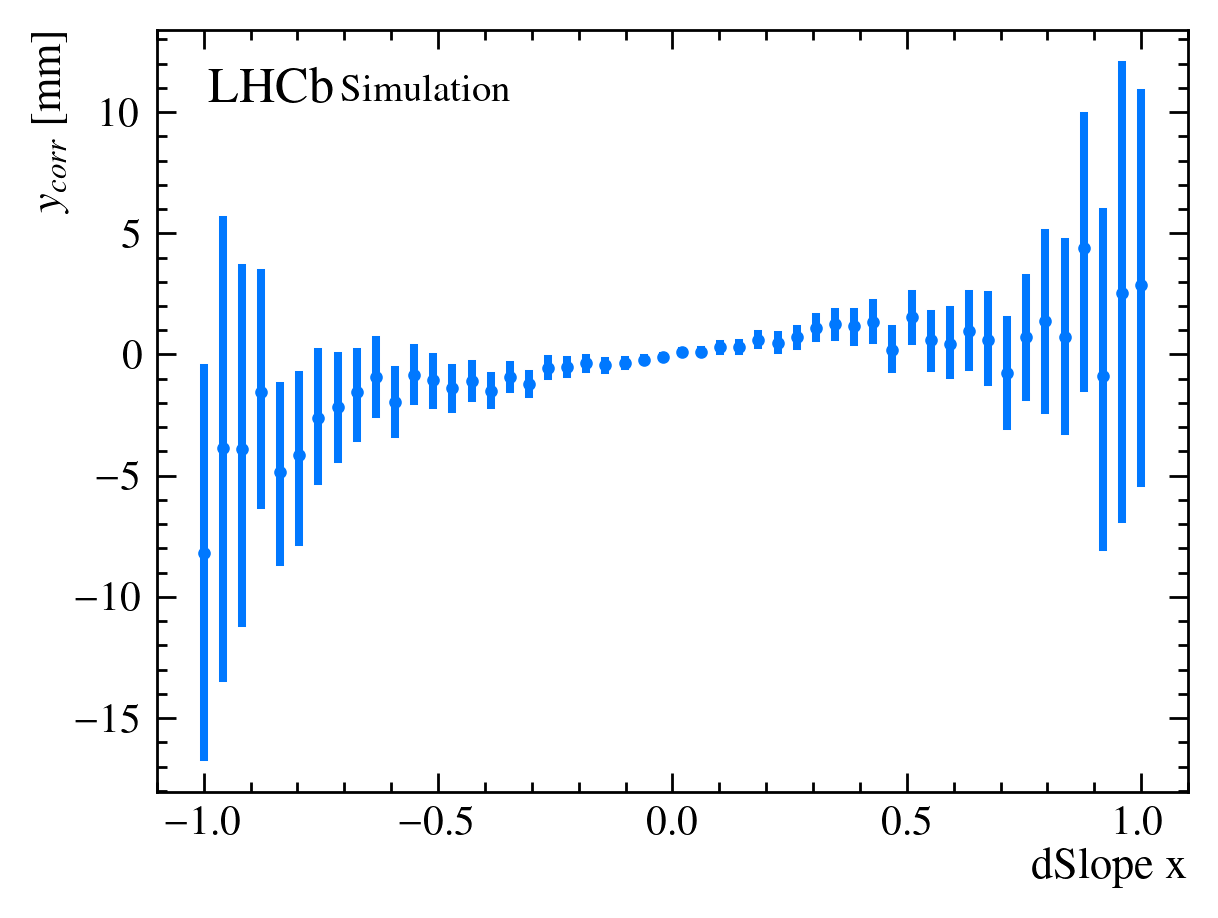

In [75]:
bins = np.linspace(-1, 1, 50)
sns.regplot(
    x=ak.to_numpy(array["dSlope_xEndT"]),
    y=ak.to_numpy(array["yDiffOut"]),
    x_bins=bins,
    fit_reg=None,
    x_estimator=np.mean,
)
plt.xlabel("dSlope x ")
plt.ylabel("$y_{corr}$ [mm]")
mplhep.lhcb.text("Simulation")
plt.show()

In [151]:
features = [
    "ideal_state_770_ty",
    # "ideal_state_9410_ty",
    # "ideal_state_770_y",
    # "ideal_state_9410_y",
    "dSlope_xEndT",
    "dSlope_yEndT",
]
target_feat = "yDiffOut"
order = 3

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

poly = PolynomialFeatures(degree=order, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)

poly_features = poly.get_feature_names_out(input_features=features)

# keep = [
#     # "ideal_state_770_ty",  #
#     # "dSlope_xEndT",  #
#     "dSlope_yEndT",  # keep
#     # "ideal_state_770_ty^2",  #
#     # "ideal_state_770_ty dSlope_xEndT",  #
#     # "ideal_state_770_ty dSlope_yEndT",  #
#     # "dSlope_xEndT^2",  # do not keep
#     "dSlope_xEndT dSlope_yEndT",  # keep
#     # "dSlope_yEndT^2",  #
#     # "ideal_state_770_ty^3",
#     # "ideal_state_770_ty^2 dSlope_xEndT",  #
#     # "ideal_state_770_ty^2 dSlope_yEndT",
#     "ideal_state_770_ty dSlope_xEndT^2",  # keep
#     # "ideal_state_770_ty dSlope_xEndT dSlope_yEndT",  #
#     "ideal_state_770_ty dSlope_yEndT^2",  # keep
#     # "dSlope_xEndT^3",  # do not keep
#     # "dSlope_xEndT^2 dSlope_yEndT",  #
#     # "dSlope_xEndT dSlope_yEndT^2",  #
#     # "dSlope_yEndT^3",
#     # "ideal_state_770_ty^4",
#     # "ideal_state_770_ty^3 dSlope_xEndT",
#     # "ideal_state_770_ty^3 dSlope_yEndT",
#     # "ideal_state_770_ty^2 dSlope_xEndT^2",  #
#     # "ideal_state_770_ty^2 dSlope_xEndT dSlope_yEndT",
#     # "ideal_state_770_ty^2 dSlope_yEndT^2",
#     # "ideal_state_770_ty dSlope_xEndT^3",  # do not keep
#     # "ideal_state_770_ty dSlope_xEndT^2 dSlope_yEndT",  #
#     # "ideal_state_770_ty dSlope_xEndT dSlope_yEndT^2",
#     # "ideal_state_770_ty dSlope_yEndT^3",
#     # "dSlope_xEndT^4",  #
#     "dSlope_xEndT^3 dSlope_yEndT",  # keep
#     # "dSlope_xEndT^2 dSlope_yEndT^2",  #
#     # "dSlope_xEndT dSlope_yEndT^3",
#     # "dSlope_yEndT^4",
#     # "ideal_state_770_ty^5",
#     # "ideal_state_770_ty^4 dSlope_xEndT",
#     # "ideal_state_770_ty^4 dSlope_yEndT",
#     # "ideal_state_770_ty^3 dSlope_xEndT^2",
#     # "ideal_state_770_ty^3 dSlope_xEndT dSlope_yEndT",
#     # "ideal_state_770_ty^3 dSlope_yEndT^2",
#     # "ideal_state_770_ty^2 dSlope_xEndT^3",  #
#     # "ideal_state_770_ty^2 dSlope_xEndT^2 dSlope_yEndT",
#     # "ideal_state_770_ty^2 dSlope_xEndT dSlope_yEndT^2",
#     # "ideal_state_770_ty^2 dSlope_yEndT^3",
#     "ideal_state_770_ty dSlope_xEndT^4",  # keep
#     # "ideal_state_770_ty dSlope_xEndT^3 dSlope_yEndT",  #
#     # "ideal_state_770_ty dSlope_xEndT^2 dSlope_yEndT^2",
#     # "ideal_state_770_ty dSlope_xEndT dSlope_yEndT^3",
#     # "ideal_state_770_ty dSlope_yEndT^4",
#     # "dSlope_xEndT^5",  #
#     "dSlope_xEndT^4 dSlope_yEndT",  # keep
#     # "dSlope_xEndT^3 dSlope_yEndT^2",  #
#     # "dSlope_xEndT^2 dSlope_yEndT^3",
#     # "dSlope_xEndT dSlope_yEndT^4",
#     # "dSlope_yEndT^5",
# ]

keep = [
    "dSlope_yEndT",  # keep
    "dSlope_xEndT dSlope_yEndT",  # keep
    "ideal_state_770_ty dSlope_xEndT^2",  # keep
    "ideal_state_770_ty dSlope_yEndT^2",  # keep
    # "dSlope_xEndT^3 dSlope_yEndT",  # do not keep
    # "ideal_state_770_ty dSlope_xEndT^4",  # keep
    # "dSlope_xEndT^4 dSlope_yEndT",  # keep
]

# keep = [
#     "ideal_state_770_ty dSlope_yEndT^2",
#     "ideal_state_770_ty dSlope_xEndT^2",
# ]
remove = [i for i, f in enumerate(poly_features) if f not in keep]

X_train_model = np.delete(X_train_model, remove, axis=1)
X_test_model = np.delete(X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove)
# print(poly_features)
lin_reg = LinearRegression()
# lin_reg = Lasso(fit_intercept=False, alpha=0.000001)
# lin_reg = Lasso(alpha=0.1)
# lin_reg = LassoCV(max_iter=2000)
# lin_reg = ElasticNet(alpha=0.1)
# lin_reg = Ridge(alpha=0)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))

intercept= 0.16257747434812642
coef= {'dSlope_yEndT': 4379.8079670973475, 'dSlope_xEndT dSlope_yEndT': 37.76975769672208, 'ideal_state_770_ty dSlope_xEndT^2': 1224.0422108322969, 'ideal_state_770_ty dSlope_yEndT^2': -18042.13200642719}
r2 score= 0.8441034202616307
RMSE = 10.185808113150346


In [148]:
koeffs = dict(zip(poly_features, lin_reg.coef_))

remove = []
for itr in koeffs.items():
    if abs(itr[1]) < 1.0:
        remove.append(itr[0])
remove

[]

In [147]:
ls_koeffs = []
for itr in koeffs.items():
    ls_koeffs.append(itr[0])
# ls_koeffs

['1', 'dSlope_xEndT^2', 'dSlope_xEndT^3', 'dSlope_xEndT^6']

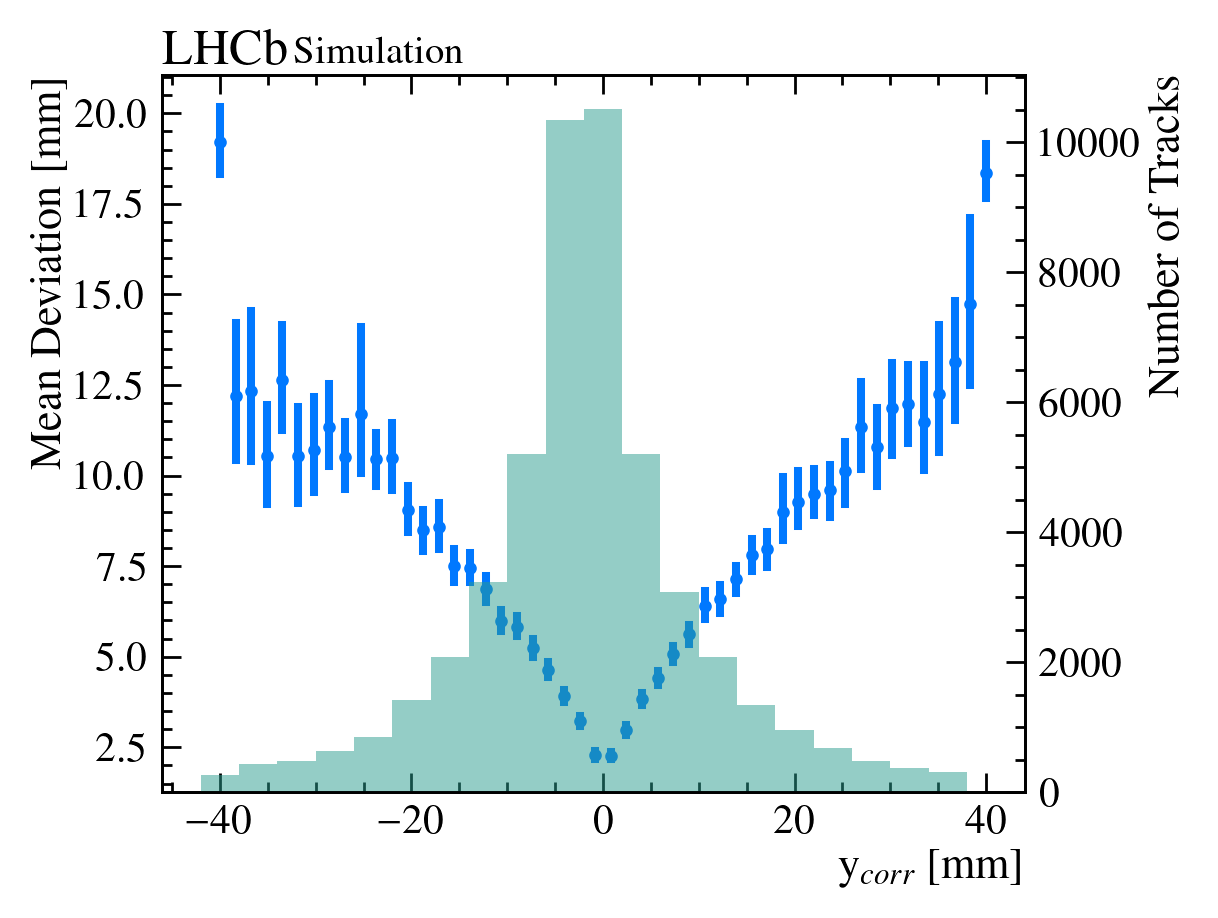

In [149]:
bins = np.linspace(-40, 40, 50)
ax = sns.regplot(
    x=y_test,
    y=abs(y_test - y_pred_test),
    x_bins=bins,
    fit_reg=None,
    x_estimator=np.mean,
    label="bla",
)
ax2 = ax.twinx()
ax2.hist(y_test,
         bins=20,
         range=[-40, 40],
         color="#2A9D8F",
         alpha=0.5,
         align="left")
ax.set_xlabel(r"y$_{corr}$ [mm]")
ax.set_ylabel("Mean Deviation [mm]")
ax2.set_ylabel("Number of Tracks")
mplhep.lhcb.text("Simulation", loc=0)
plt.show()

In [ ]:
features = [
    "ideal_state_770_ty",
    "ideal_state_770_tx",
    "dSlope_xEndT",
    "dSlope_yEndT",
    "dSlope_xEndT_abs",
    "dSlope_yEndT_abs",
]
target_feat = "yDiffEndT"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42
)

poly = PolynomialFeatures(degree=6, include_bias=False)
X_train_model = poly.fit_transform(X_train)
X_test_model = poly.fit_transform(X_test)
poly_features = poly.get_feature_names_out(input_features=features)
keep = [
    #'dSlope_xEndT',
    "dSlope_yEndT",  # keep
    #'dSlope_yEndT_abs',
    #'ty dSlope_xEndT',
    #'ty dSlope_yEndT',
    "ideal_state_770_ty dSlope_xEndT_abs",  # keep
    "ideal_state_770_ty dSlope_yEndT_abs",  # keep
    "ideal_state_770_ty dSlope_yEndT^2",  # keep
    "ideal_state_770_ty dSlope_xEndT^2",  # keep
    #'tx dSlope_xEndT',
    #'tx dSlope_xEndT_abs',
    #'tx dSlope_yEndT',
    "ideal_state_770_ty ideal_state_770_tx dSlope_xEndT",  # keep
    "ideal_state_770_tx^2 dSlope_yEndT",  # keep
    #'ty^2 dSlope_xEndT',
    #'ty^2 dSlope_yEndT',
    #'ty^2 dSlope_xEndT_abs',
    #'ty^2 tx dSlope_xEndT',
    #'ty tx^2 dSlope_yEndT',
    "ideal_state_770_ty ideal_state_770_tx^2 dSlope_xEndT_abs",  # keep
    "ideal_state_770_ty^3 ideal_state_770_tx dSlope_xEndT",  # keep
    #'ty tx^3 dSlope_xEndT',
    #'ty^3 dSlope_yEndT_abs',
]
do_not_keep = [
    "dSlope_xEndT",
    "dSlope_yEndT_abs",
    "ideal_state_770_ty dSlope_xEndT",
    "ideal_state_770_tx dSlope_xEndT",
    "ideal_state_770_tx dSlope_xEndT_abs",
    "ideal_state_770_tx dSlope_yEndT",
    "ideal_state_770_ty^2 dSlope_xEndT",
    "ideal_state_770_ty^3 dSlope_yEndT_abs",
    "ideal_state_770_ty ideal_state_770_tx dSlope_yEndT",
    "ideal_state_770_ty ideal_state_770_tx^3 dSlope_xEndT",
    "ideal_state_770_ty ideal_state_770_tx^2 dSlope_yEndT",
]
reduce = True
if reduce:
    remove = [i for i, f in enumerate(poly_features) if (keep and f not in keep)]
    X_train_model = np.delete(X_train_model, remove, axis=1)
    X_test_model = np.delete(X_test_model, remove, axis=1)
    poly_features = np.delete(poly_features, remove)
    print(poly_features)
if not reduce:
    remove = [
        i
        for i, f in enumerate(poly_features)
        if ("dSlope_" not in f)
        or ("EndT^" in f)
        or ("abs^" in f)
        or ("EndT dSlope" in f)
        or ("abs dSlope" in f)
    ]
    X_train_model = np.delete(X_train_model, remove, axis=1)
    X_test_model = np.delete(X_test_model, remove, axis=1)
    poly_features = np.delete(poly_features, remove)
    # print(poly_features)
    lin_reg = Lasso(fit_intercept=False, alpha=0.000001)
else:
    lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X_train_model, y_train)
y_pred_test = lin_reg.predict(X_test_model)
print("intercept=", lin_reg.intercept_)
print(
    "coef=",
    {
        k: v
        for k, v in zip(poly_features, lin_reg.coef_)
        if abs(v) > 1.0 and k not in keep and k not in do_not_keep
    },
)
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print(
    "straight RMSE =",
    mean_squared_error(
        array["ideal_state_9410_y"],
        array["ideal_state_770_y"]
        + array["ideal_state_770_ty"]
        * (array["ideal_state_9410_z"] - array["ideal_state_770_z"]),
        squared=False,
    ),
)
print(format_array("y_xEndT_diff", lin_reg.coef_))